# GLM: Linear Regression

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pymc3 import  *
import theano
import pandas as pd
from statsmodels.formula.api import glm as glm_sm
import statsmodels.api as sm
from pandas.tools.plotting import scatter_matrix

Simple example
==============

Lets generate some data with known slope and intercept and fit a simple linear GLM.

In [2]:
size = 50
true_intercept = 1
true_slope = 2
x = np.linspace(0, 1, size)
y = true_intercept + x*true_slope + np.random.normal(scale=.5, size=size)
data = {'x': x, 'y': y}

The `glm.linear_component()` function can be used to generate the output variable y_est and coefficients of the specified linear model.

Optimization terminated successfully.
         Current function value: 119.399118
         Iterations: 4
         Function evaluations: 8
         Gradient evaluations: 8


100%|██████████| 2000/2000 [00:03<00:00, 500.92it/s]


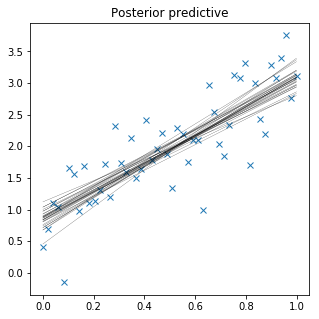

In [3]:
with Model() as model:
    lm = glm.LinearComponent.from_formula('y ~ x', data)
    sigma = Uniform('sigma', 0, 20)
    y_obs = Normal('y_obs', mu=lm.y_est, sd=sigma, observed=y)
    start = find_MAP(vars=[sigma])
    step = Slice(model.vars)
    trace = sample(2000, step=step, start=start)

plt.figure(figsize=(5, 5))
plt.plot(x, y, 'x')
plot_posterior_predictive_glm(trace)

Since there are a couple of general linear models that are being used over and over again (Normally distributed noise, logistic regression etc), the `glm.glm()` function simplifies the above step by creating the likelihood (y_obs) and its priors (sigma) for us. Since we are working in the model context, the random variables are all added to the model behind the scenes. This function also automatically finds a good starting point which it returns.

Note that the below call to `glm()` is producing exactly the same model as above, just more succinctly.

100%|██████████| 2000/2000 [00:04<00:00, 495.69it/s]


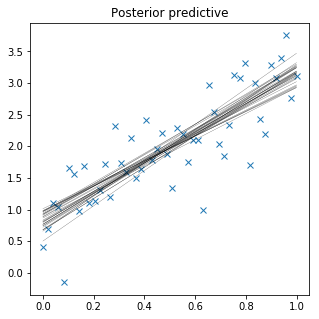

In [4]:
with Model() as model:
    GLM.from_formula('y ~ x', data)
    trace = sample(2000, Slice(model.vars))

plt.figure(figsize=(5, 5))
plt.plot(x, y, 'x')
plot_posterior_predictive_glm(trace)

Robust GLM
==========

Lets try the same model but with a few outliers in the data.

In [5]:
x_out = np.append(x, [.1, .15, .2])
y_out = np.append(y, [8, 6, 9])
data_outlier = dict(x=x_out, y=y_out)

100%|██████████| 2000/2000 [00:03<00:00, 530.20it/s]


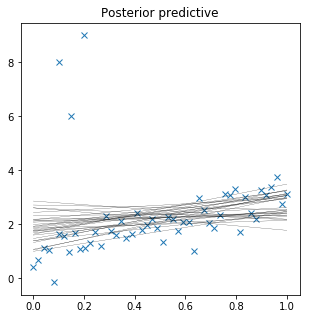

In [6]:
with Model() as model:
    GLM.from_formula('y ~ x', data_outlier)
    trace = sample(2000, Slice(model.vars))

plt.figure(figsize=(5, 5))
plt.plot(x_out, y_out, 'x')
plot_posterior_predictive_glm(trace)

Because the normal distribution does not have a lot of mass in the tails, an outlier will affect the fit strongly.

Instead, we can replace the Normal likelihood with a student T distribution which has heavier tails and is more robust towards outliers. While this could be done with the `linear_compoment()` function and manually defining the T likelihood we can use the `glm()` function for more automation. By default this function uses a normal likelihood. To define the usage of a T distribution instead we can pass a family object that contains information on how to link the output to `y_est` (in this case we explicitly use the Identity link function which is also the default) and what the priors for the T distribution are. Here we fix the degrees of freedom `nu` to 1.5.

100%|██████████| 2000/2000 [00:03<00:00, 528.11it/s]


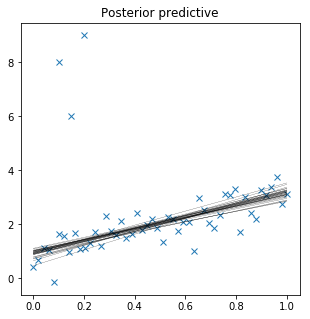

In [7]:
with Model() as model_robust:
    family = glm.families.StudentT(link=glm.families.Identity(),  
                                   priors={'nu': 1.5,
                                           'lam': Uniform.dist(0, 20)})
    GLM.from_formula('y ~ x', data_outlier, family=family)    
    trace = sample(2000, Slice(model_robust.vars))

plt.figure(figsize=(5, 5))
plt.plot(x_out, y_out, 'x')
plot_posterior_predictive_glm(trace)

# Hierarchical GLM

In [8]:
sat_data = pd.read_csv(get_data('Guber1999data.txt'))

In [9]:
with Model() as model_sat:
    grp_mean = Normal('grp_mean', mu=0, sd=10)
    grp_sd = Uniform('grp_sd', 0, 200)
    # Define priors for intercept and regression coefficients.
    priors = {'Intercept': Normal.dist(mu=sat_data.sat_t.mean(), sd=sat_data.sat_t.std()),
          'spend': Normal.dist(mu=grp_mean, sd=grp_sd),
          'stu_tea_rat': Normal.dist(mu=grp_mean, sd=grp_sd),
          'salary': Normal.dist(mu=grp_mean, sd=grp_sd),
          'prcnt_take': Normal.dist(mu=grp_mean, sd=grp_sd)
    }
    GLM.from_formula('sat_t ~ spend + stu_tea_rat + salary + prcnt_take', sat_data, priors=priors)
    trace_sat = sample(500, NUTS())

100%|█████████▉| 499/500 [00:49<00:00,  8.14it/s]/home/jovyan/pymc3/pymc3/step_methods/hmc/nuts.py:235: UserWarning: Chain 0 contains only 500 samples.
  warnings.warn('Chain %s contains only %s samples.' % (chain, n))
/home/jovyan/pymc3/pymc3/step_methods/hmc/nuts.py:237: UserWarning: Step size tuning was enabled throughout the whole trace. You might want to specify the number of tuning steps.
  warnings.warn('Step size tuning was enabled throughout the whole '
/opt/conda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|██████████| 500/500 [00:49<00:00, 10.06it/s]


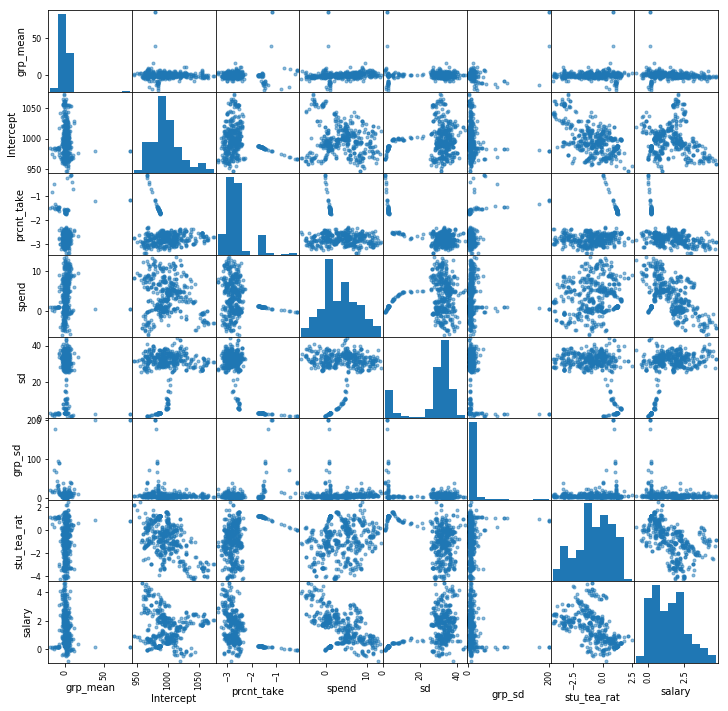

In [10]:
scatter_matrix(trace_to_dataframe(trace_sat), figsize=(12,12));

In [11]:
with Model() as model_sat:
    grp_mean = Normal('grp_mean', mu=0, sd=10)
    grp_prec = Gamma('grp_prec', alpha=1, beta=.1, testval=1.)
    slope = StudentT.dist(mu=grp_mean, lam=grp_prec, nu=1)
    intercept = Normal.dist(mu=sat_data.sat_t.mean(), sd=sat_data.sat_t.std())
    GLM.from_formula('sat_t ~ spend + stu_tea_rat + salary + prcnt_take', sat_data,
        priors={'Intercept': intercept, 'Regressor': slope})
    trace_sat = sample(500, NUTS())

100%|██████████| 500/500 [00:46<00:00,  8.75it/s]/home/jovyan/pymc3/pymc3/step_methods/hmc/nuts.py:235: UserWarning: Chain 0 contains only 500 samples.
  warnings.warn('Chain %s contains only %s samples.' % (chain, n))
/home/jovyan/pymc3/pymc3/step_methods/hmc/nuts.py:237: UserWarning: Step size tuning was enabled throughout the whole trace. You might want to specify the number of tuning steps.
  warnings.warn('Step size tuning was enabled throughout the whole '
/opt/conda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)



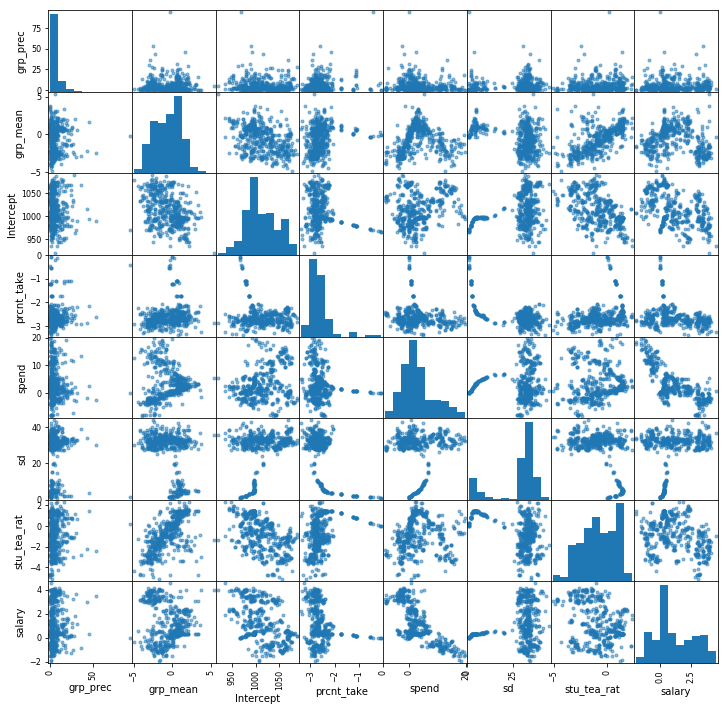

In [12]:
scatter_matrix(trace_to_dataframe(trace_sat), figsize=(12,12));

In [13]:
tdf_gain = 5.
with Model() as model_sat:
    grp_mean = Normal('grp_mean', mu=0, sd=10)
    grp_prec = Gamma('grp_prec', alpha=1, beta=.1, testval=1.)
    slope = StudentT.dist(mu=grp_mean, lam=grp_prec, nu=1) #grp_df)
    intercept = Normal.dist(mu=sat_data.sat_t.mean(), sd=sat_data.sat_t.std())
    GLM.from_formula('sat_t ~ spend + stu_tea_rat + salary + prcnt_take', sat_data,
                priors={'Intercept': intercept, 'Regressor': slope})

    trace_sat = sample(2000, NUTS())

100%|██████████| 2000/2000 [04:06<00:00,  8.15it/s]/home/jovyan/pymc3/pymc3/step_methods/hmc/nuts.py:237: UserWarning: Step size tuning was enabled throughout the whole trace. You might want to specify the number of tuning steps.
  warnings.warn('Step size tuning was enabled throughout the whole '
/opt/conda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)



# Logistic Regression

In [14]:
htwt_data = pd.read_csv(get_data('HtWt.csv'))
htwt_data.head()

,male,height,weight
0,0,63.2,168.7
1,0,68.7,169.8
2,0,64.8,176.6
3,0,67.9,246.8
4,1,68.9,151.6


In [15]:
m = glm_sm('male ~ height + weight', htwt_data, family=sm.families.Binomial()).fit()
print(m.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   male   No. Observations:                   70
Model:                            GLM   Df Residuals:                       67
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -28.298
Date:                Wed, 26 Apr 2017   Deviance:                       56.597
Time:                        13:38:28   Pearson chi2:                     62.8
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -45.2059     10.887     -4.152      0.000     -66.545     -23.867
height         0.6571      0.164      4.018      0.0

In [16]:
with Model() as model_htwt:
    GLM.from_formula('male ~ height + weight', htwt_data, family=glm.families.Binomial())
    trace_htwt = sample(1000, NUTS())

 99%|█████████▉| 994/1000 [00:06<00:00, 154.11it/s]/home/jovyan/pymc3/pymc3/step_methods/hmc/nuts.py:237: UserWarning: Step size tuning was enabled throughout the whole trace. You might want to specify the number of tuning steps.
  warnings.warn('Step size tuning was enabled throughout the whole '
/opt/conda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|██████████| 1000/1000 [00:06<00:00, 154.89it/s]


                mean        std        min        25%        50%        75%  \
height      0.736415   0.203463  -0.059605   0.609917   0.743361   0.849871   
Intercept -50.604382  13.547952 -95.424476 -58.374699 -50.709506 -42.690393   
weight      0.010281   0.011235  -0.033394   0.002963   0.010126   0.017817   

                max  
height     1.373401  
Intercept  1.076201  
weight     0.046414  
P(weight < 0) =  0.163
P(height < 0) =  0.006


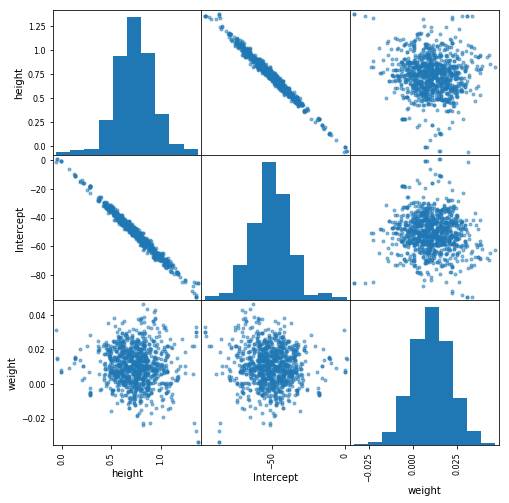

In [17]:
trace_df = trace_to_dataframe(trace_htwt)
print(trace_df.describe().drop('count').T)
scatter_matrix(trace_df, figsize=(8, 8))
print("P(weight < 0) = ", (trace_df['weight'] < 0).mean())
print("P(height < 0) = ", (trace_df['height'] < 0).mean())

## Bayesian Logistic Lasso

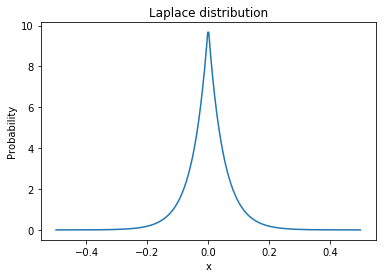

In [18]:
lp = Laplace.dist(mu=0, b=0.05)
x_eval = np.linspace(-.5, .5, 300)
plt.plot(x_eval, theano.tensor.exp(lp.logp(x_eval)).eval())
plt.xlabel('x')
plt.ylabel('Probability')
plt.title('Laplace distribution');

 96%|█████████▌| 480/500 [00:02<00:00, 193.51it/s]/home/jovyan/pymc3/pymc3/step_methods/hmc/nuts.py:235: UserWarning: Chain 0 contains only 500 samples.
  warnings.warn('Chain %s contains only %s samples.' % (chain, n))
/home/jovyan/pymc3/pymc3/step_methods/hmc/nuts.py:237: UserWarning: Step size tuning was enabled throughout the whole trace. You might want to specify the number of tuning steps.
  warnings.warn('Step size tuning was enabled throughout the whole '
/opt/conda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|██████████| 500/500 [00:02<00:00, 170.32it/s]


                mean       std        min        25%        50%        75%  \
height      0.335467  0.106041  -0.033747   0.265635   0.335860   0.408644   
Intercept -24.118712  6.938635 -41.729539 -28.794806 -24.183141 -19.480237   
weight      0.011749  0.008146  -0.012925   0.006426   0.011893   0.017335   

                max  
height     0.627600  
Intercept -1.642436  
weight     0.034942  


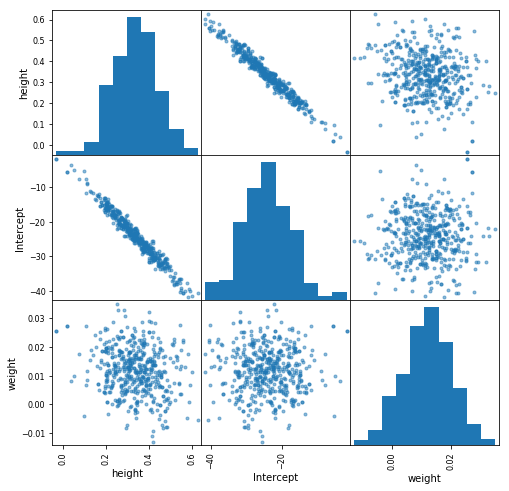

In [19]:
with Model() as model_lasso:
    # Define priors for intercept and regression coefficients.
    priors = {'Intercept': Normal.dist(mu=0, sd=50),
              'Regressor': Laplace.dist(mu=0, b=0.05)
    }
    GLM.from_formula('male ~ height + weight', htwt_data, family=glm.families.Binomial(),
                    priors=priors)
    
    trace_lasso = sample(500, NUTS())
    
trace_df = trace_to_dataframe(trace_lasso)
scatter_matrix(trace_df, figsize=(8, 8));
print(trace_df.describe().drop('count').T)